In [1]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from scipy import linalg as la
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [2]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""
        
        #Initialize everything given
        self.random_state = random_state
        self.rank = rank
        self.maxiter = maxiter
        self.tol = tol
        
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""
        #Set the random seed
        np.random.seed(self.random_state)
        
        #Get a random W and H
        self.W = np.random.rand(m,self.rank)
        self.H = np.random.rand(self.rank,n)
        
        return self.W,self.H

      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        
        #Iterate through
        for i in range(self.maxiter):
            
            #Use convex optimization to solve the minimization problem
            X = cp.Variable(self.W.shape, nonneg=True)
            X.value = self.W
            Y = cp.Variable(self.H.shape, nonneg=True)
            Y.value = self.H
            obj = cp.Minimize(cp.norm(V-X@Y.value, 'fro'))
            
            prob = cp.Problem(obj)
            optimalval = prob.solve()
            
            #Solve the problem both ways each iteration
            obj = cp.Minimize(cp.norm(V-X.value@Y,'fro'))

            prob = cp.Problem(obj)
            optimalval = prob.solve()
            
            #Save H and W as Y and X respectively
            self.H = Y.value
            self.W = X.value
            
            
        return self.W, self.H
                


    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        
        return self.W@self.H


In [5]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    #Given this V
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )
    
    m,n = V.shape
    
    #Use rank = 2 and initialize
    nmf = NMFRecommender(rank=2)
    nmf.initialize_matrices(m,n)
    
    #Fit and reconstruct
    W,H = nmf.fit(V)
    newV = nmf.reconstruct()
    
    return np.round(W,2),np.round(H,2), sum(H[1]>H[0])
    
prob3()
    

(array([[0.43, 1.56],
        [0.73, 2.67],
        [0.26, 1.23],
        [2.77, 0.  ],
        [0.  , 0.37]]),
 array([[0.  , 0.73, 1.08, 1.45, 0.35, 0.37],
        [0.59, 0.77, 0.07, 0.  , 0.8 , 0.77]]),
 4)

In [6]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


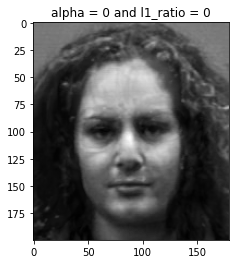

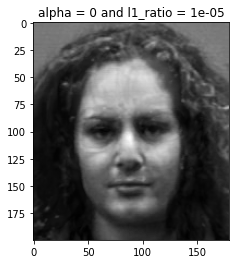

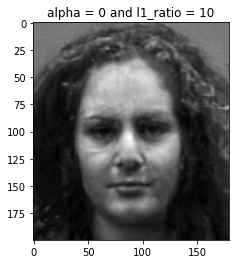

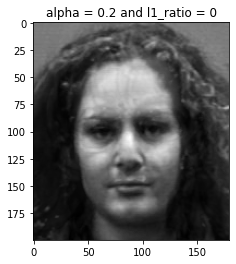

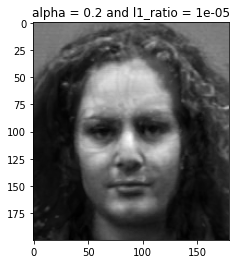

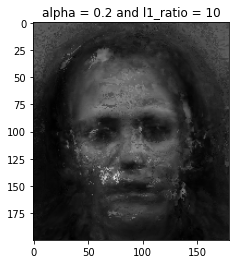

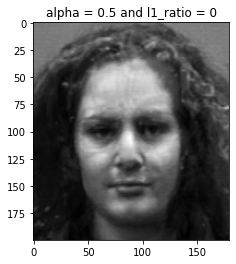

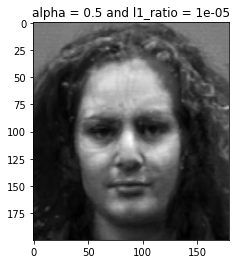

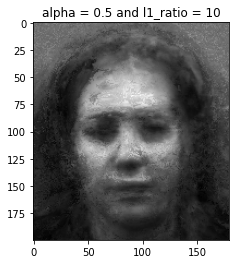

1

In [22]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    #Get faces and initialize alpha and l1 variables
    faces = get_faces()
    alpha = [0,.2,.5]
    l1_ratio = [0,1e-5,10]
    
    #Iterate through alphas and ratios
    for a in alpha:
        for l in l1_ratio:
            #Fit for each iteration
            model = NMF(n_components=75, alpha = a, l1_ratio = l)
            
            #Fit and find W and H
            W = model.fit_transform(faces)
            H = model.components_
            
            #Reconstruct V and get second face
            V = (W@H)[:,2]
            
            #Set title then show
            plt.title(f"alpha = {a} and l1_ratio = {l}")
            show(V, plt_show = True)
    
    return

prob4()

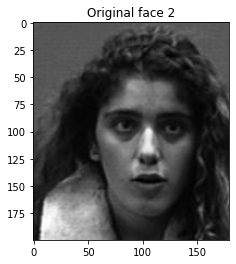

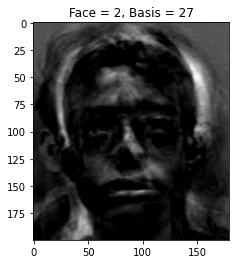

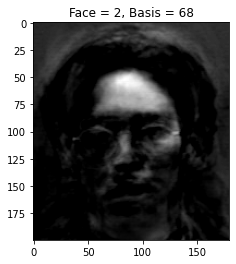

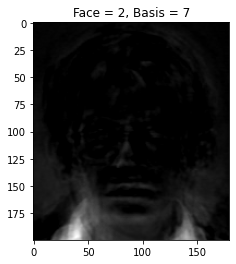

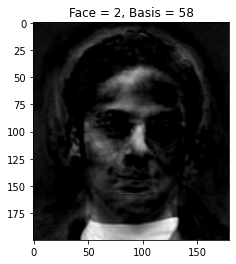

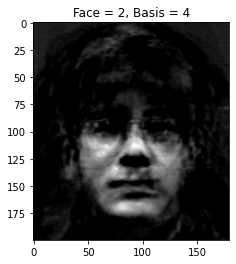

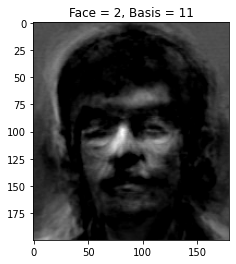

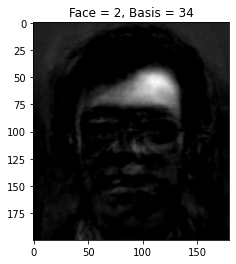

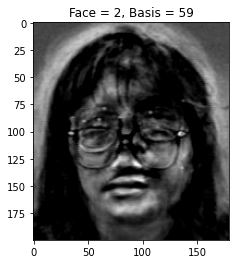

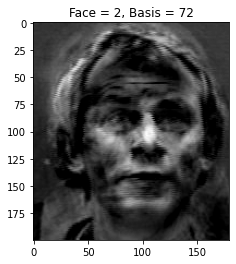

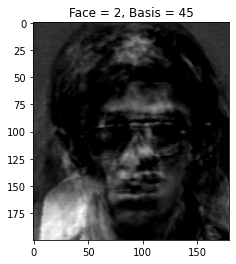

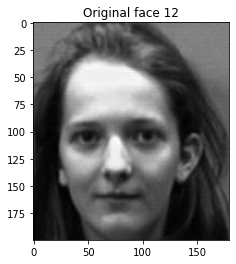

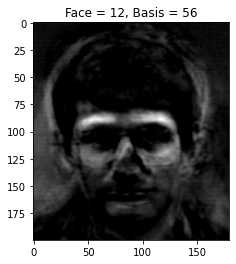

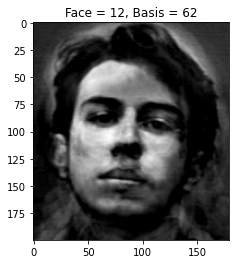

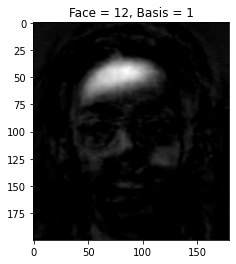

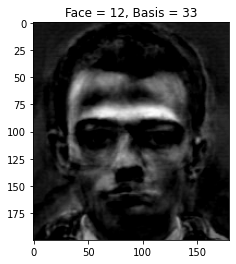

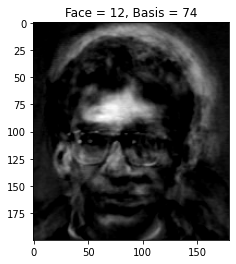

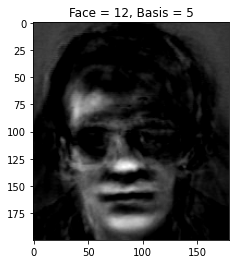

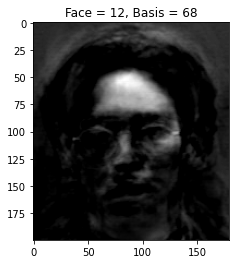

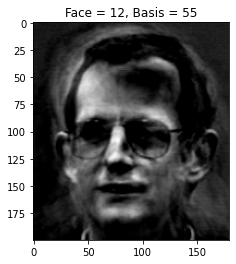

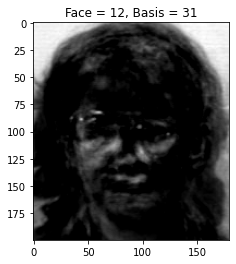

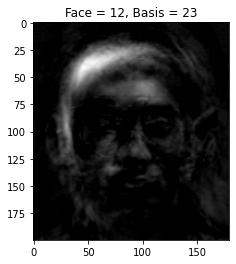

In [30]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    #Get Faces
    faces = get_faces()
    
    #Train model with arbitrary parameters
    model = NMF(n_components=75, alpha = .2, l1_ratio = 1e-5)
    
    #Fit and get W and H
    W = model.fit_transform(faces)
    H = model.components_
    
    #For both chosen faces find the best bases
    for i in [1,11]:
        basis = np.argsort(H[:,i])[-10:]
        
        #Plot original face
        plt.title(f"Original face {i+1}")
        show(faces[:,i], plt_show = True)
        
        #For faces in the top 10 bases
        for j in basis:
            #Get the face and plot with title
            V = W[:,j]
            plt.title(f"Face = {i+1}, Basis = {j}")
            show(V, plt_show = True)
    
    return 

prob5()

In [34]:
print("My face 2 has a narrow face so the other basis faces have narrow faces too including a narrow nose.\
    I can also see a hint of her large jacket collar on the left in some of the other faces.\
    My face 12 has a very large and lopsided forehead and tiny eyes and mouth. You'll notice the other\
    faces also have large lopsided foreheads and tiny eyes and mouth slits. It may be picking up on\
    glasses because her eyes are sunken in to produce dark shadows around her eyes.")

My face 2 has a narrow face so the other basis faces have narrow faces too including a narrow nose.    I can also see a hint of her large jacket collar on the left in some of the other faces.    My face 12 has a very large and lopsided forehead and tiny eyes and mouth. You'll notice the other    faces also have large lopsided foreheads and tiny eyes and mouth slits. It may be picking up on    glasses because her eyes are sunken in to produce dark shadows around her eyes.
